In [1]:
# load in the libraries we will use
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
import visuals as vs
%matplotlib inline

C:\Users\jmaxi.LSUMC-MASTER\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
C:\Users\jmaxi.LSUMC-MASTER\AppData\Local\Continuum\Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\jmaxi.LSUMC-MASTER\AppData\Local\Continuum\Anaconda\lib\site-packages\sklearn\learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module 

In [2]:
train = pd.read_csv('houseTrain.csv')
test = pd.read_csv('houseTest.csv')
print len(train)
print len(test)

1460
1459


In [3]:
# First split the training data into the features and the target
features = train.drop(['Id', 'SalePrice'], axis=1)
target = train.SalePrice

In [4]:
# How many features are there?
print len(features.columns.values)

79


In [5]:
# Which columns are missing values?
nan_columns = features.columns[pd.isnull(features).any()].tolist()

In [6]:
for i in nan_columns:
    print '{0}: {1} {2}'.format(i, features[i].isnull().sum(), features[i].dtypes)

LotFrontage: 259 float64
Alley: 1369 object
MasVnrType: 8 object
MasVnrArea: 8 float64
BsmtQual: 37 object
BsmtCond: 37 object
BsmtExposure: 38 object
BsmtFinType1: 37 object
BsmtFinType2: 38 object
Electrical: 1 object
FireplaceQu: 690 object
GarageType: 81 object
GarageYrBlt: 81 float64
GarageFinish: 81 object
GarageQual: 81 object
GarageCond: 81 object
PoolQC: 1453 object
Fence: 1179 object
MiscFeature: 1406 object


In [7]:
# Let's turn the above into a function
def missing_data_info(df):
    '''
    Takes: a pandas dataframe which is checked for missing data in the columns. Uses any() method to check for 
           missing data.
           
    Returns: prints out the name of columns with missing data, the number of missing values, and the dtype of the column
             and returns a dictionary of the printed data in the form column_name: [#_missing_values, col_dtype]'''
    nan_columns = df.columns[pd.isnull(df).any()].tolist()
    nan_dict = {}
    for i in nan_columns:
        print '{0}: {1} {2}'.format(i, df[i].isnull().sum(), features[i].dtypes)
        nan_dict[i] = [df[i].isnull().sum(), features[i].dtypes]
    return nan_dict

In [8]:
# The Alley, FireplaceQu, PoolQC, Fence, MiscFeatures objects should be dropped
variables_to_drop = ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [9]:
def graph_mean_on_scatter(df, x_name, y_name):
    '''
    Input:
            df: the pandas data frame the data is contained in
            x_name: the name of the df column to plot on the x-axis
            y_name: the name of the df column to plot on the y-axis
    Dependencies: 
            import seaborn as sns
            import numpy as np
            import matplotlib.pyplot as plt
    Returns: 
            A regplot which has any missing values plotted separately in order to evaluate the usefullness of 
            substituting in the mean for the missing data.'''
    missing = pd.DataFrame(data=df[x_name][df[x_name].isnull()], columns=[x_name])
    missing[y_name] = df[y_name][df[x_name].isnull()]
    missing[x_name].fillna(value=np.nanmean(df[x_name]), inplace=True)
    
    sns.regplot(x=x_name, y=y_name, data=df)
    plt.plot(missing[x_name], missing[y_name], 's')
    plt.show()
    return

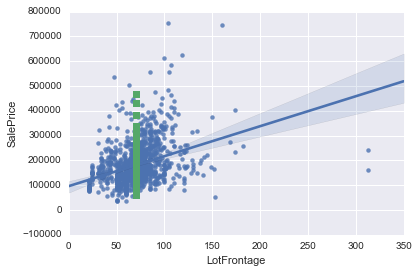

In [10]:
# Now need to decide how to fill the missing values from the remaining factors
# Let's start with LotFrontage
graph_mean_on_scatter(train, 'LotFrontage', 'SalePrice')

In [11]:
# The mean LotFrontage values fit right in with the rest of the data. Let's fill in the missing data using these values
mean_LotFrontage = np.nanmean(features.LotFrontage)
features.LotFrontage.fillna(value=mean_LotFrontage, inplace=True)

# check that LotFrontage column isn't missing any daya
missing_data_info(features)

#success!

Alley: 1369 object
MasVnrType: 8 object
MasVnrArea: 8 float64
BsmtQual: 37 object
BsmtCond: 37 object
BsmtExposure: 38 object
BsmtFinType1: 37 object
BsmtFinType2: 38 object
Electrical: 1 object
FireplaceQu: 690 object
GarageType: 81 object
GarageYrBlt: 81 float64
GarageFinish: 81 object
GarageQual: 81 object
GarageCond: 81 object
PoolQC: 1453 object
Fence: 1179 object
MiscFeature: 1406 object


{'Alley': [1369, dtype('O')],
 'BsmtCond': [37, dtype('O')],
 'BsmtExposure': [38, dtype('O')],
 'BsmtFinType1': [37, dtype('O')],
 'BsmtFinType2': [38, dtype('O')],
 'BsmtQual': [37, dtype('O')],
 'Electrical': [1, dtype('O')],
 'Fence': [1179, dtype('O')],
 'FireplaceQu': [690, dtype('O')],
 'GarageCond': [81, dtype('O')],
 'GarageFinish': [81, dtype('O')],
 'GarageQual': [81, dtype('O')],
 'GarageType': [81, dtype('O')],
 'GarageYrBlt': [81, dtype('float64')],
 'MasVnrArea': [8, dtype('float64')],
 'MasVnrType': [8, dtype('O')],
 'MiscFeature': [1406, dtype('O')],
 'PoolQC': [1453, dtype('O')]}

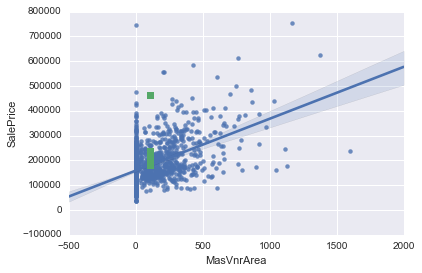

In [12]:
# Let's try the same strategy above for MasVnrArea which is the Masonry Veneer Area
graph_mean_on_scatter(train, 'MasVnrArea', 'SalePrice')

In [13]:
# I'm going to use the mean value to fill the missing data
mean_MasVnrArea = np.nanmean(features.MasVnrArea)
features.MasVnrArea.fillna(value=mean_MasVnrArea, inplace=True)

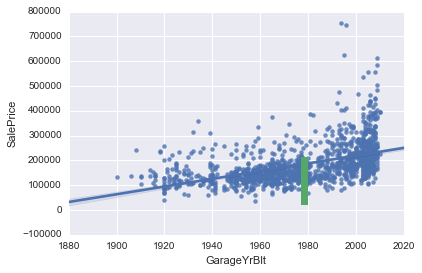

In [14]:
# Look at how using the mean value works for GarageYrBlt
graph_mean_on_scatter(train, 'GarageYrBlt', 'SalePrice')

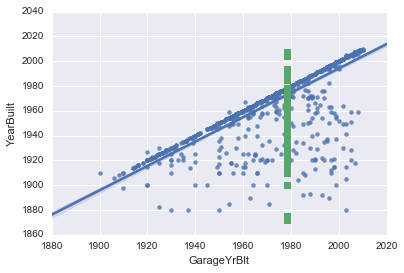

In [15]:
# I don't like that so much of imputed data is weighted down below the trend line. 
# It might be that the value for GarageYrBlt doens't exists is because there is no garage! 
# Looking back at the number of values of missing data for the garage features,
# there are an equal number of missing features. This would suggest that those homes don't have a garage.
# And in fact, the same pattern is true for the basement features. 
# We can test this hypothesis by looking at the comparison between GarageYrBlt and YearBlt
graph_mean_on_scatter(train, 'GarageYrBlt', 'YearBuilt')

In [16]:
# Looks like most of the garages were built when the house was built, so this likely isn't going to add much information
# I'll add the garage features to the variables_to_drop list
variables_to_drop.extend(['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond'])

In [17]:
features.drop(variables_to_drop, axis=1, inplace=True)
missing_data_info(features)

MasVnrType: 8 object
BsmtQual: 37 object
BsmtCond: 37 object
BsmtExposure: 38 object
BsmtFinType1: 37 object
BsmtFinType2: 38 object
Electrical: 1 object


{'BsmtCond': [37, dtype('O')],
 'BsmtExposure': [38, dtype('O')],
 'BsmtFinType1': [37, dtype('O')],
 'BsmtFinType2': [38, dtype('O')],
 'BsmtQual': [37, dtype('O')],
 'Electrical': [1, dtype('O')],
 'MasVnrType': [8, dtype('O')]}

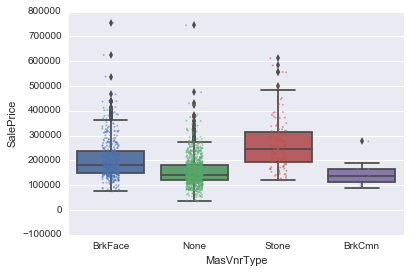

In [18]:
# Let's look through the remaining columns that are missing data points. These are all categorical variables
# We'll start with MasVnrType
sns.boxplot(x='MasVnrType', y='SalePrice', data=train)
sns.stripplot(x="MasVnrType", y="SalePrice", data=train,
              size=2, jitter=True, edgecolor="gray", alpha=0.5)
# The BrkFace veneer type looks like it is right in the middle. Since we used the mean values to for the 
# MasVnrArea, I'll use BrkFace as the "mean" value to use as the replacement for this feaure

In [19]:
features.MasVnrType.fillna(value='BrkFace', inplace=True)

### Basement Condition
The BsmtCond feature documentation says that NA values mean there is no basement. I want to see if it shows up as a factor

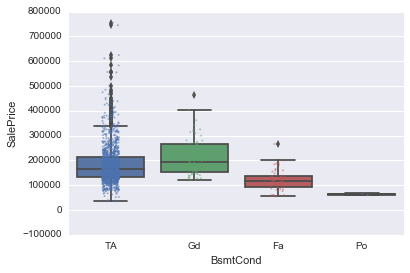

In [20]:
sns.boxplot(x='BsmtCond', y='SalePrice', data=train)
sns.stripplot(x='BsmtCond', y='SalePrice', data=train, size=2, jitter=True, edgecolor="gray", alpha=0.5)

In [21]:
# Since 'Na' string in the basement features doesn't count as a category, I'm going to replace the Na values with the
# string 'None'
for i in ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual']:
    features.loc[:,i].fillna(value='NoBsmt', inplace=True)

In [22]:
missing_data_info(features)

Electrical: 1 object


{'Electrical': [1, dtype('O')]}

1379    167500
Name: SalePrice, dtype: int64

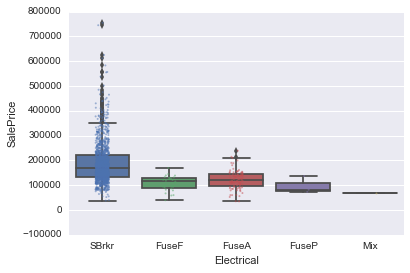

In [23]:
# only 1 feature left with null values! This feature ranks the circuit breaker/fuse box quality of the house
# let's take a look at it
sns.boxplot(x='Electrical', y='SalePrice', data=train)
sns.stripplot(x='Electrical', y='SalePrice', data=train, size = 2, jitter=True, alpha=0.5)
train.SalePrice[train.Electrical.isnull()]

In [24]:
# Since so many of the values are SBrkr and the price of the house missing the data is pretty close to the median of
# the SBrkr values, I'm going to assign the missing value to SBrkr
features.Electrical.fillna(value="SBrkr", inplace=True)

#and check that it worked
missing_data_info(features)

{}

In [25]:
# success! That was a good pratice of investigating and filling missing features. Now I will use just the numeric
# data to train a DecisionTreeRegressor model and make another submission
# Ben Hamner: "The best data scientists rapidly iterate."
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numeric_features = features.select_dtypes(include=numerics)

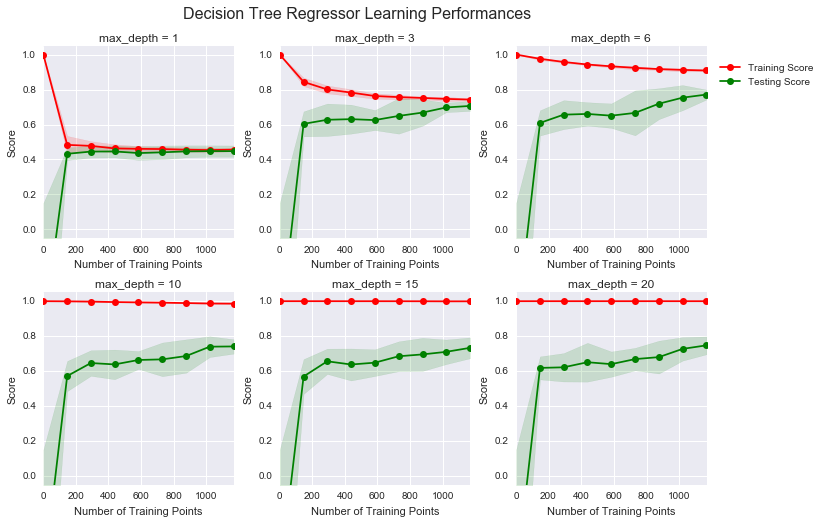

In [26]:
vs.ModelLearning(numeric_features, target)

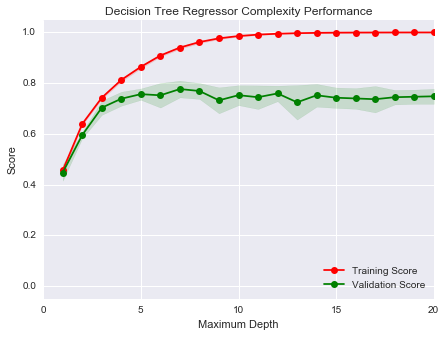

In [27]:
vs.ModelComplexity(numeric_features, target)

In [28]:
# I'm going with a max depth of 7
reg = DecisionTreeRegressor(max_depth = 7)
reg.fit(numeric_features, target)

DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [29]:
# prepare the test data
test.drop(variables_to_drop, axis=1, inplace=True)
numeric_test_features = test.select_dtypes(include=numerics)
numeric_test_features.drop('Id', axis=1, inplace=True)

C:\Users\jmaxi.LSUMC-MASTER\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [30]:
# need to impute the missing data
the_missing_test_data = missing_data_info(numeric_test_features)
for k in the_missing_test_data.keys():
    numeric_test_features[k].fillna(value=np.nanmean(numeric_test_features[k]), inplace=True)
missing_data_info(numeric_test_features)

LotFrontage: 227 float64
MasVnrArea: 15 float64
BsmtFinSF1: 1 int64
BsmtFinSF2: 1 int64
BsmtUnfSF: 1 int64
TotalBsmtSF: 1 int64
BsmtFullBath: 2 int64
BsmtHalfBath: 2 int64
GarageCars: 1 int64
GarageArea: 1 int64


C:\Users\jmaxi.LSUMC-MASTER\AppData\Local\Continuum\Anaconda\lib\site-packages\pandas\core\generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


{}

In [31]:
# No missing data points in the test set so:
DTRegressor = reg.predict(numeric_test_features)
print len(DTRegressor)
test_id = test.Id
print len(test_id)
DTR_submission = pd.DataFrame(data=DTRegressor, index=test_id, columns=['SalePrice'])
print DTR_submission.head()
DTR_submission.to_csv('DTR_submission3.csv')

1459
1459
          SalePrice
Id                 
1461  133041.653846
1462  142368.333333
1463  193060.000000
1464  170276.356061
1465  194311.636364


In [32]:
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

In [33]:
# this was worse than the first model!
# Let's do hyperparameter tuning
# split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size = 0.2, random_state=0)
# make the scorer
r2_scorer = make_scorer(performance_metric)
parameters = {'max_depth':[1,3,6,10,20], 'min_samples_split':[2,5,10,15,18,20,23,25,28,30,40,50,100], 
              'min_samples_leaf':[1,5,10,12,15,17,20,40]}
reg = DecisionTreeRegressor()
clf = GridSearchCV(reg, parameters)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 5, 10, 15, 18, 20, 23, 25, 28, 30, 40, 50, 100], 'max_depth': [1, 3, 6, 10, 20], 'min_samples_leaf': [1, 5, 10, 12, 15, 17, 20, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [34]:
clf.best_score_

0.7583286341793033

In [35]:
clf.best_params_

{'max_depth': 20, 'min_samples_leaf': 12, 'min_samples_split': 30}

In [36]:
GS_results = pd.DataFrame(clf.cv_results_).sort_values('mean_test_score', axis=0, ascending=False)

In [37]:
GS_results.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
464,0.005333,0.000000,0.758329,0.846362,20,12,30,"{u'min_samples_split': 30, u'max_depth': 20, u...",1,0.764049,0.842514,0.747592,0.841600,0.763330,0.854972,0.007542,0.000000,0.007593,0.006100
341,0.010333,0.000000,0.758227,0.882828,10,10,15,"{u'min_samples_split': 15, u'max_depth': 10, u...",2,0.726562,0.892488,0.780184,0.879552,0.768017,0.876444,0.007318,0.000000,0.022963,0.006948
339,0.005000,0.000000,0.758227,0.882828,10,10,5,"{u'min_samples_split': 5, u'max_depth': 10, u'...",2,0.726562,0.892488,0.780184,0.879552,0.768017,0.876444,0.007071,0.000000,0.022963,0.006948
443,0.005333,0.000000,0.758135,0.882912,20,10,5,"{u'min_samples_split': 5, u'max_depth': 20, u'...",4,0.726562,0.892488,0.780184,0.879552,0.767741,0.876697,0.007542,0.000000,0.022924,0.006871
447,0.005333,0.005333,0.758135,0.882912,20,10,20,"{u'min_samples_split': 20, u'max_depth': 20, u...",4,0.726562,0.892488,0.780184,0.879552,0.767741,0.876697,0.007542,0.007542,0.022924,0.006871


In [38]:
clf.score(X_test, y_test)

0.7436876946701767

In [39]:
DTR = clf.predict(numeric_test_features)
print len(DTRegressor)
test_id = test.Id
print len(test_id)
DTR_submission = pd.DataFrame(data=DTR, index=test_id, columns=['SalePrice'])
print DTR_submission.head()
DTR_submission.to_csv('DTR_submission4.csv')

1459
1459
          SalePrice
Id                 
1461  133083.315789
1462  158894.642857
1463  189416.000000
1464  196796.875000
1465  202730.769231


In [40]:
# The decision tree with the hypertuned parameters increased my score by 188 positions (0.03 decrease in 
# the root mean squared error of my predictions).

In [41]:
categorical_variables = features.select_dtypes(include= ['object'])

In [42]:
categorical_variables.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Y,WD,Normal


In [43]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
le = LabelEncoder()
categorical_encoded = categorical_variables.apply(le.fit_transform)


In [44]:
cat_reg = DecisionTreeRegressor()
cat_reg.fit(categorical_encoded, target)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [45]:
numeric_categorical_test = test.select_dtypes(['object'])
numeric_categorical_test = numeric_categorical_test.apply(le.fit_transform)
numeric_categorical_test.head()

C:\Users\jmaxi.LSUMC-MASTER\AppData\Local\Continuum\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
0,3,1,3,3,1,4,0,12,1,2,...,4,0,4,1,3,4,7,2,9,4
1,4,1,0,3,1,0,0,12,2,2,...,6,0,4,1,3,3,7,2,9,4
2,4,1,0,3,1,4,0,8,2,2,...,6,0,2,1,3,4,7,2,9,4
3,4,1,0,3,1,4,0,8,2,2,...,6,0,0,1,3,3,7,2,9,4
4,4,1,0,1,1,4,0,22,2,2,...,6,0,0,1,3,3,7,2,9,4


In [46]:
DTR = cat_reg.predict(numeric_categorical_test)
print len(DTRegressor)
test_id = test.Id
print len(test_id)
DTR_submission = pd.DataFrame(data=DTR, index=test_id, columns=['SalePrice'])
print DTR_submission.head()
DTR_submission.to_csv('DTR_submission5.csv')
# submission score of 0.39 - pretty bad!

1459
1459
      SalePrice
Id             
1461   128000.0
1462   110500.0
1463   145000.0
1464   140000.0
1465    93000.0


In [47]:
def make_submission(test_data, test_data_index, predictor, k):
    '''
    test_data = a pandas dataframe containing the test data
    predictor = a trained classifier
    k = the number of the entry. Used to keep older entries from being overwritten
    output: writes a csv file to the current directory'''
    predictions = predictor.predict(test_data)
    test_id = test_data_index
    submission = pd.DataFrame(data=predictions, index=test_id, columns=['SalePrice'])
    print submission.head()
    submission.to_csv('DTR_submission{}.csv'.format(k))

In [48]:
make_submission(numeric_categorical_test, test.Id, cat_reg, 6)

      SalePrice
Id             
1461   128000.0
1462   110500.0
1463   145000.0
1464   140000.0
1465    93000.0


In [49]:
# concatenate the categorical_encoded and the numeric_features dataframes
all_features = pd.concat([categorical_encoded, numeric_features], axis=1)
all_features.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,3,1,3,3,0,4,0,5,2,2,...,548,0,61,0,0,0,0,0,2,2008
1,3,1,3,3,0,2,0,24,1,2,...,460,298,0,0,0,0,0,0,5,2007
2,3,1,0,3,0,4,0,5,2,2,...,608,0,42,0,0,0,0,0,9,2008
3,3,1,0,3,0,0,0,6,2,2,...,642,0,35,272,0,0,0,0,2,2006
4,3,1,0,3,0,2,0,15,2,2,...,836,192,84,0,0,0,0,0,12,2008


In [50]:
X_train, X_test, y_train, y_test = train_test_split(all_features, target, test_size = 0.2, random_state=0)
reg = DecisionTreeRegressor()
clf = GridSearchCV(reg, parameters)
clf.fit(X_train, y_train)
print clf.best_score_
print clf.best_params_
print clf.score(X_test, y_test)
all_features_test = pd.concat([numeric_categorical_test, numeric_test_features], axis=1)
make_submission(all_features_test, test.Id, clf, 6)
# these predictions are worse than the hypertuned submission using only the numeric features (submission 4)
# this is not what I was expecting because this model gave higher scores on the hold-out set duing the 
# GridSearchCV and gave a better score on the held out test data

0.760107996644
{'min_samples_split': 30, 'max_depth': 10, 'min_samples_leaf': 1}
0.69909607094
          SalePrice
Id                 
1461  114774.718750
1462  157979.545455
1463  194477.272727
1464  194477.272727
1465  203257.142857


In [ ]:
# I think the next thing to do is clean up this notebook and then go through the categorical variables to determine
# which are ordinal and which are not, determine how to replace eadh variable type and then use one hot encoding on
# the non-ordinal categorical variables and label encoding on the ordinal ones